# Unseen Object Instance Segmentation

In [1]:
%matplotlib inline
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "0" # TODO: Change this if you have more than 1 GPU

import sys
import json
from time import time
import glob

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

# My libraries. Ugly hack to import from sister directory
import src.data_augmentation as data_augmentation
import src.segmentation as segmentation
import src.evaluation as evaluation
import src.util.utilities as util_
import src.util.flowlib as flowlib

## Depth Seeding Network Parameters

In [2]:
dsn_config = {
    
    # Sizes
    'feature_dim' : 64, # 32 would be normal

    # Mean Shift parameters (for 3D voting)
    'max_GMS_iters' : 10, 
    'epsilon' : 0.05, # Connected Components parameter
    'sigma' : 0.02, # Gaussian bandwidth parameter
    'num_seeds' : 200, # Used for MeanShift, but not BlurringMeanShift
    'subsample_factor' : 5,
    
    # Misc
    'min_pixels_thresh' : 500,
    'tau' : 15.,
    
}

## Region Refinement Network parameters

In [3]:
rrn_config = {
    
    # Sizes
    'feature_dim' : 64, # 32 would be normal
    'img_H' : 224,
    'img_W' : 224,
    
    # architecture parameters
    'use_coordconv' : False,
    
}

# UOIS-Net-3D Parameters

In [4]:
uois3d_config = {
    
    # Padding for RGB Refinement Network
    'padding_percentage' : 0.25,
    
    # Open/Close Morphology for IMP (Initial Mask Processing) module
    'use_open_close_morphology' : True,
    'open_close_morphology_ksize' : 9,
    
    # Largest Connected Component for IMP module
    'use_largest_connected_component' : True,
    
}

In [5]:
checkpoint_dir = '/home/biobe/workspace/uois/checkpoints/'#'/home/chrisxie/projects/uois/checkpoints/' # TODO: change this to directory of downloaded models
dsn_filename = checkpoint_dir + 'DepthSeedingNetwork_3D_TOD_checkpoint.pt'
rrn_filename = checkpoint_dir + 'RRN_OID_checkpoint.pt'
uois3d_config['final_close_morphology'] = 'TableTop_v5' in rrn_filename
uois_net_3d = segmentation.UOISNet3D(uois3d_config, 
                                     dsn_filename,
                                     dsn_config,
                                     rrn_filename,
                                     rrn_config
                                    )

Let's use 0 GPUs for DSN!
cpu
filename :  /home/biobe/workspace/uois/checkpoints/DepthSeedingNetwork_3D_TOD_checkpointpt
Loaded DSNWrapper model
Let's use 0 GPUs for RRN!
cpu
filename :  /home/biobe/workspace/uois/checkpoints/RRN_OID_checkpointpt
Loaded RRNWrapper model


## Run on example OSD/OCID images

We provide a few [OSD](https://www.acin.tuwien.ac.at/en/vision-for-robotics/software-tools/osd/) and [OCID](https://www.acin.tuwien.ac.at/en/vision-for-robotics/software-tools/object-clutter-indoor-dataset/) images and run the network on them. Evaluation metrics are shown for each of the images.

In [6]:
example_images_dir = os.path.abspath('.') + '/example_images/'

OSD_image_files = sorted(glob.glob(example_images_dir + '/OSD_*.npy'))
OCID_image_files = sorted(glob.glob(example_images_dir + '/OCID_*.npy'))
N = len(OSD_image_files) + len(OCID_image_files)

rgb_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)
xyz_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)
label_imgs = np.zeros((N, 480, 640), dtype=np.uint8)

for i, img_file in enumerate(OSD_image_files + OCID_image_files):
    d = np.load(img_file, allow_pickle=True, encoding='bytes').item()
    
    # RGB
    rgb_img = d['rgb']
    rgb_imgs[i] = data_augmentation.standardize_image(rgb_img)

    # XYZ
    xyz_imgs[i] = d['xyz']

    # Label
    label_imgs[i] = d['label']
    
batch = {
    'rgb' : data_augmentation.array_to_tensor(rgb_imgs),
    'xyz' : data_augmentation.array_to_tensor(xyz_imgs),
}

In [8]:
print("Number of images: {0}".format(N))

### Compute segmentation masks ###
st_time = time()
fg_masks, center_offsets, initial_masks, seg_masks = uois_net_3d.run_on_batch(batch)
total_time = time() - st_time
print('Total time taken for Segmentation: {0} seconds'.format(round(total_time, 3)))
print('FPS: {0}'.format(round(N / total_time,3)))

# Get results in numpy

seg_masks = seg_masks.cpu().numpy()
fg_masks = fg_masks.cpu().numpy()
center_offsets = center_offsets.cpu().numpy().transpose(0,2,3,1)
initial_masks = initial_masks.cpu().numpy()
"""
seg_masks = seg_masks.cpu().numpy()
fg_masks = fg_masks.cpu().numpy()
center_offsets = center_offsets.cpu().numpy().transpose(0,2,3,1)
initial_masks = initial_masks.cpu().numpy()
"""



Number of images: 4
Total time taken for Segmentation: 40.404 seconds
FPS: 0.099


'\nseg_masks = seg_masks.cpu().numpy()\nfg_masks = fg_masks.cpu().numpy()\ncenter_offsets = center_offsets.cpu().numpy().transpose(0,2,3,1)\ninitial_masks = initial_masks.cpu().numpy()\n'

/home/biobe/workspace/uois/src/evaluation.py:141: RuntimeWarning: invalid value encountered in double_scalars
  F[i,j] = (2 * prec * rec) / (prec + rec)
/home/biobe/workspace/uois/src/evaluation.py:141: RuntimeWarning: invalid value encountered in double_scalars
  F[i,j] = (2 * prec * rec) / (prec + rec)


Image 1 Metrics:
{'Objects F-measure': 0.8757525998905309, 'Objects Precision': 0.8379783771650893, 'Objects Recall': 0.917093142272262, 'Boundary F-measure': 0.8007469688022273, 'Boundary Precision': 0.7389513108614232, 'Boundary Recall': 0.8738212842388864, 'obj_detected': 7, 'obj_detected_075': 6, 'obj_gt': 6, 'obj_detected_075_percentage': 1.0}
Image 2 Metrics:
{'Objects F-measure': 0.7643413917996307, 'Objects Precision': 0.7308988809242231, 'Objects Recall': 0.8009909894024086, 'Boundary F-measure': 0.6147233925962932, 'Boundary Precision': 0.6063513066490241, 'Boundary Recall': 0.6233299075025693, 'obj_detected': 20, 'obj_detected_075': 9, 'obj_gt': 15, 'obj_detected_075_percentage': 0.6}
Image 3 Metrics:
{'Objects F-measure': 0.7950010542255276, 'Objects Precision': 0.7762970726959647, 'Objects Recall': 0.8146285893860234, 'Boundary F-measure': 0.759050352014755, 'Boundary Precision': 0.858842617631152, 'Boundary Recall': 0.680034497628288, 'obj_detected': 8, 'obj_detected_075'

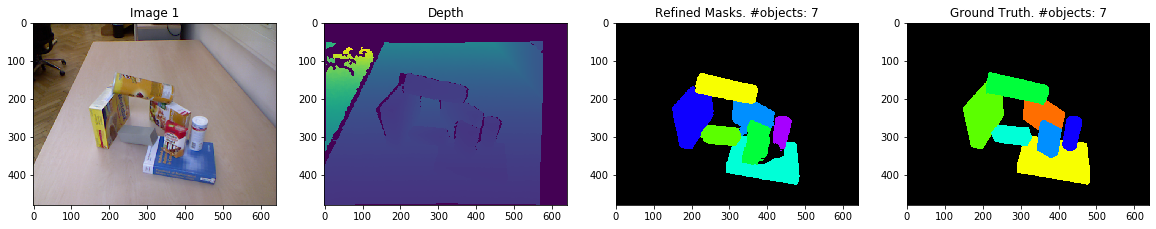

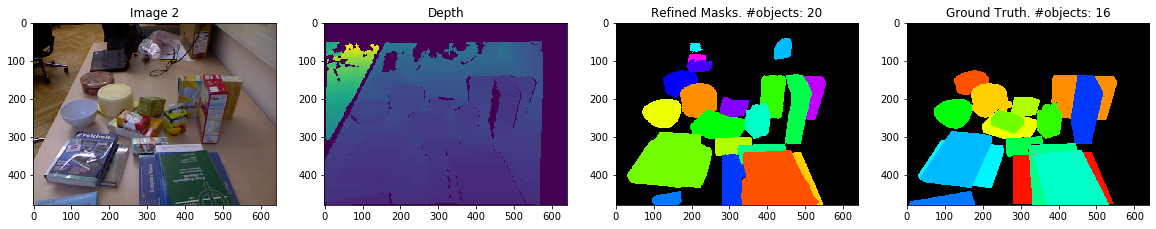

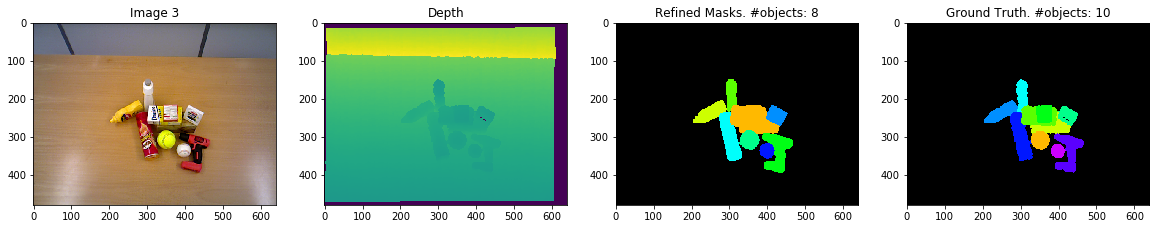

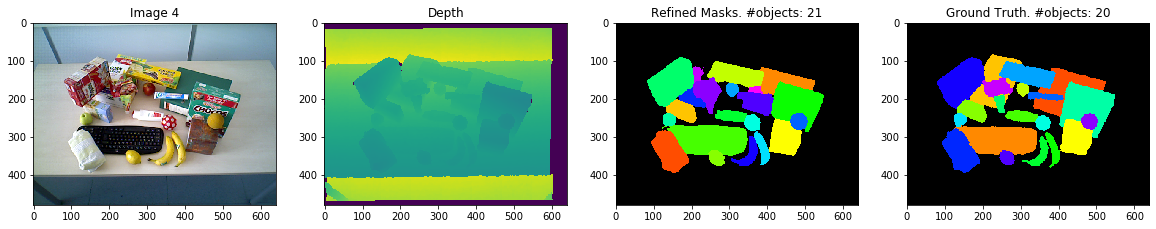

In [9]:
rgb_imgs = util_.torch_to_numpy(batch['rgb'].cpu(), is_standardized_image=True)
total_subplots = 6

fig_index = 1
for i in range(N):
    
    num_objs = max(np.unique(seg_masks[i,...]).max(), np.unique(label_imgs[i,...]).max()) + 1
    
    rgb = rgb_imgs[i].astype(np.uint8)
    depth = xyz_imgs[i,...,2]
    seg_mask_plot = util_.get_color_mask(seg_masks[i,...], nc=num_objs)
    gt_masks = util_.get_color_mask(label_imgs[i,...], nc=num_objs)
    
    images = [rgb, depth, seg_mask_plot, gt_masks]
    titles = [f'Image {i+1}', 'Depth',
              f"Refined Masks. #objects: {np.unique(seg_masks[i,...]).shape[0]-1}",
              f"Ground Truth. #objects: {np.unique(label_imgs[i,...]).shape[0]-1}"
             ]
    util_.subplotter(images, titles, fig_num=i+1)
    
    # Run evaluation metric
    eval_metrics = evaluation.multilabel_metrics(seg_masks[i,...], label_imgs[i])
    print(f"Image {i+1} Metrics:")
    print(eval_metrics)